In [25]:
import pandas as pd

file_path = 'train.csv'
data = pd.read_csv(file_path)
data.head()


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


Limpieza de datos


In [26]:
data['text'] = data['text'].str.lower()


In [27]:
import re

# Eliminar caracteres especiales
data['text'] = data['text'].apply(lambda x: re.sub(r"[@#']", '', x))


In [28]:
# Eliminar URLs
data['text'] = data['text'].apply(lambda x: re.sub(r"http\S+", '', x))


In [29]:
# Eliminar emoticones
data['text'] = data['text'].apply(lambda x: re.sub(r'[^\w\s,]', '', x))


In [30]:
# Eliminar signos de puntuación
data['text'] = data['text'].apply(lambda x: re.sub(r'[^\w\s]', '', x))


In [31]:
# Eliminar números
data['text'] = data['text'].apply(lambda x: re.sub(r'\d+', '', x))


In [32]:
from collections import Counter

# Dividir datos en desastres y no desastres
disaster_tweets = data[data['target'] == 1]
non_disaster_tweets = data[data['target'] == 0]

# Calcular la frecuencia de palabras
disaster_words = Counter(" ".join(disaster_tweets['text']).split())
non_disaster_words = Counter(" ".join(non_disaster_tweets['text']).split())

# Mostrar las 10 palabras más comunes en cada categoría
disaster_words.most_common(10), non_disaster_words.most_common(10)


([('the', 1358),
  ('in', 1159),
  ('a', 931),
  ('of', 922),
  ('to', 757),
  ('and', 501),
  ('on', 417),
  ('for', 399),
  ('is', 349),
  ('i', 321)],
 [('the', 1905),
  ('a', 1257),
  ('to', 1188),
  ('i', 1077),
  ('and', 917),
  ('of', 901),
  ('in', 818),
  ('you', 664),
  ('is', 595),
  ('my', 544)])

In [33]:
from collections import Counter

# Lista manual de stopwords en inglés
manual_stopwords = set([
    "i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", 
    "yours", "yourself", "yourselves", "he", "him", "his", "himself", "she", 
    "her", "hers", "herself", "it", "its", "itself", "they", "them", "their", 
    "theirs", "themselves", "what", "which", "who", "whom", "this", "that", 
    "these", "those", "am", "is", "are", "was", "were", "be", "been", "being", 
    "have", "has", "had", "having", "do", "does", "did", "doing", "a", "an", 
    "the", "and", "but", "if", "or", "because", "as", "until", "while", "of", 
    "at", "by", "for", "with", "about", "against", "between", "into", "through", 
    "during", "before", "after", "above", "below", "to", "from", "up", "down", 
    "in", "out", "on", "off", "over", "under", "again", "further", "then", 
    "once", "here", "there", "when", "where", "why", "how", "all", "any", 
    "both", "each", "few", "more", "most", "other", "some", "such", "no", 
    "nor", "not", "only", "own", "same", "so", "than", "too", "very", "s", 
    "t", "can", "will", "just", "don", "should", "now","amp"
])

data['clean_text'] = data['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in manual_stopwords]))

# Dividir datos en desastres y no desastres
disaster_tweets = data[data['target'] == 1]
non_disaster_tweets = data[data['target'] == 0]

# Calcular la frecuencia de palabras sin stopwords
disaster_words_clean = Counter(" ".join(disaster_tweets['clean_text']).split())
non_disaster_words_clean = Counter(" ".join(non_disaster_tweets['clean_text']).split())

# Mostrar las 10 palabras más comunes en cada categoría
top_disaster_words = disaster_words_clean.most_common(10)
top_non_disaster_words = non_disaster_words_clean.most_common(10)

top_disaster_words, top_non_disaster_words


([('fire', 178),
  ('news', 140),
  ('via', 121),
  ('disaster', 117),
  ('california', 111),
  ('suicide', 110),
  ('police', 107),
  ('people', 105),
  ('killed', 93),
  ('like', 92)],
 [('like', 253),
  ('im', 243),
  ('new', 168),
  ('get', 163),
  ('dont', 141),
  ('one', 127),
  ('body', 112),
  ('via', 99),
  ('would', 97),
  ('video', 96)])

# ¿Qué palabras cree que le servirán para hacer un mejor modelo de clasificación?¿vale la pena explorar bigramas o trigramas para analizar contexto?

Las palabras que probablemente servirán para un mejor modelo de clasificación incluyen "fire," "disaster," "suicide," "police," y "killed," ya que están directamente relacionadas con eventos de emergencia o desastres. Explorar bigramas o trigramas sí vale la pena porque pueden capturar el contexto en el que aparecen estas palabras, como en las frases "fire in," "police respond," o "disaster struck," lo que mejora la precisión del modelo al reducir ambigüedades y agregar información contextual.

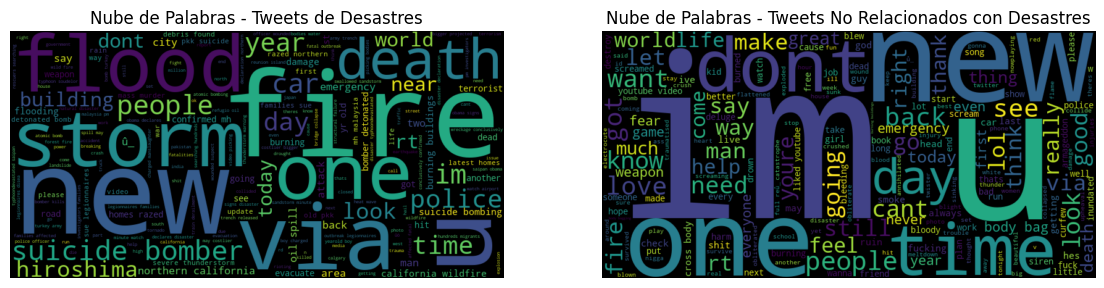

In [34]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Crear nubes de palabras
disaster_wordcloud = WordCloud(width=800, height=400).generate(" ".join(disaster_tweets['clean_text']))
non_disaster_wordcloud = WordCloud(width=800, height=400).generate(" ".join(non_disaster_tweets['clean_text']))
plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
plt.imshow(disaster_wordcloud, interpolation='bilinear')
plt.title('Nube de Palabras - Tweets de Desastres')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(non_disaster_wordcloud, interpolation='bilinear')
plt.title('Nube de Palabras - Tweets No Relacionados con Desastres')
plt.axis('off')

plt.show()


In [35]:
!pip install wordcloud


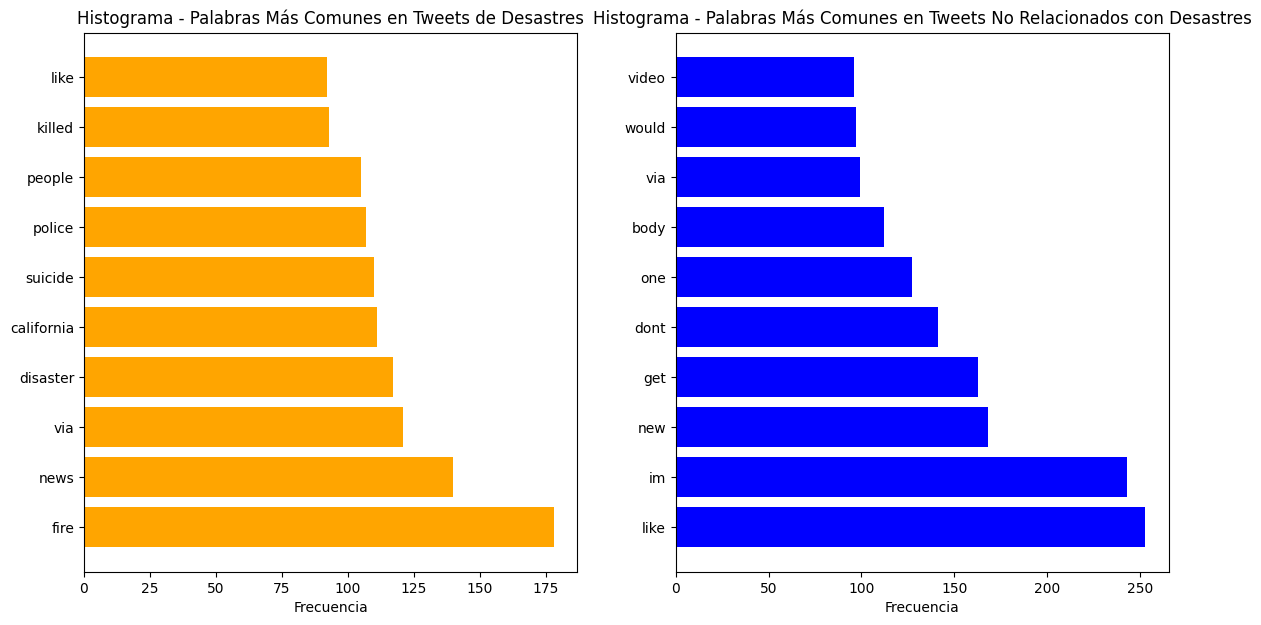

In [36]:

# Crear histograma de las palabras más frecuentes
disaster_top_words = [word for word, count in disaster_words_clean.most_common(10)]
disaster_top_counts = [count for word, count in disaster_words_clean.most_common(10)]

non_disaster_top_words = [word for word, count in non_disaster_words_clean.most_common(10)]
non_disaster_top_counts = [count for word, count in non_disaster_words_clean.most_common(10)]

plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
plt.barh(disaster_top_words, disaster_top_counts, color='orange')
plt.title('Histograma - Palabras Más Comunes en Tweets de Desastres')
plt.xlabel('Frecuencia')
plt.subplot(1, 2, 2)
plt.barh(non_disaster_top_words, non_disaster_top_counts, color='blue')
plt.title('Histograma - Palabras Más Comunes en Tweets No Relacionados con Desastres')
plt.xlabel('Frecuencia')

plt.show()


Los histogramas y nubes de palabras muestran que los tweets relacionados con desastres contienen términos clave como "fire," "disaster," y "death," que están claramente asociados con emergencias y eventos trágicos, mientras que los tweets no relacionados se centran en palabras más generales como "like" y "im," que reflejan conversaciones cotidianas. Las palabras "via" y "new" aparecen en ambas categorías, lo que sugiere que son términos comunes en redes sociales sin un valor distintivo significativo para la clasificación.

In [37]:



max_words = 10000  # Número máximo de palabras a considerar en el vocabulario
max_len = 100  # Longitud máxima de las secuencias de texto

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(data['clean_text'])

sequences = tokenizer.texts_to_sequences(data['clean_text'])
padded_sequences = pad_sequences(sequences, maxlen=max_len)

X_train, X_val, y_train, y_val = train_test_split(padded_sequences, data['target'], test_size=0.2, random_state=42)


NameError: name 'Tokenizer' is not defined

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=128, input_length=max_len))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


model.summary()


c:\Users\marce\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:

history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_val, y_val))


Epoch 1/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 15s 63ms/step - accuracy: 0.6537 - loss: 0.6111 - val_accuracy: 0.8011 - val_loss: 0.4506
Epoch 2/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 11s 60ms/step - accuracy: 0.8771 - loss: 0.3046 - val_accuracy: 0.7636 - val_loss: 0.4864
Epoch 3/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 11s 57ms/step - accuracy: 0.9291 - loss: 0.1893 - val_accuracy: 0.7544 - val_loss: 0.5496
Epoch 4/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 10s 54ms/step - accuracy: 0.9522 - loss: 0.1357 - val_accuracy: 0.7485 - val_loss: 0.6655
Epoch 5/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 11s 55ms/step - accuracy: 0.9642 - loss: 0.1063 - val_accuracy: 0.7426 - val_loss: 0.8064


In [ ]:
# Cargar los datos de prueba
test_data_path = 'test.csv'
test_data = pd.read_csv(test_data_path)

test_data['text'] = test_data['text'].str.lower()
test_data['text'] = test_data['text'].apply(lambda x: re.sub(r"[@#']", '', x))
test_data['text'] = test_data['text'].apply(lambda x: re.sub(r"http\S+", '', x))
test_data['text'] = test_data['text'].apply(lambda x: re.sub(r'[^\w\s,]', '', x))
test_data['text'] = test_data['text'].apply(lambda x: re.sub(r'[^\w\s]', '', x))
test_data['text'] = test_data['text'].apply(lambda x: re.sub(r'\d+', '', x))

test_data['clean_text'] = test_data['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in manual_stopwords]))


test_sequences = tokenizer.texts_to_sequences(test_data['clean_text'])
test_padded_sequences = pad_sequences(test_sequences, maxlen=max_len)

# Realizar predicciones
predictions = model.predict(test_padded_sequences)


predictions = (predictions > 0.5).astype(int)


102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step


In [ ]:

predictions_df = pd.DataFrame({
    'Tweet': test_data['text'],
    'Prediction': predictions.flatten()  
})

print(predictions_df.head(10))


                                               Tweet  Prediction
0                 just happened a terrible car crash           1
1  heard about earthquake is different cities sta...           1
2  there is a forest fire at spot pond geese are ...           1
3              apocalypse lighting spokane wildfires           1
4        typhoon soudelor kills  in china and taiwan           1
5                      were shakingits an earthquake           1
6  theyd probably still show more life than arsen...           0
7                                    hey how are you           0
8                                    what a nice hat           0
9                                           fuck off           0


nuevo modelo

In [ ]:
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:

tfidf = TfidfVectorizer(max_features=10000)
X = tfidf.fit_transform(data['clean_text'])
X_train, X_val, y_train, y_val = train_test_split(X, data['target'], test_size=0.2, random_state=42)

Modelo svm

In [ ]:
from sklearn import svm
from sklearn.metrics import accuracy_score, classification_report

model_svm = svm.SVC(kernel='linear', probability=True)
model_svm.fit(X_train, y_train)
y_pred = model_svm.predict(X_val)


In [ ]:

accuracy = accuracy_score(y_val, y_pred)
print(f"Accuracy: {accuracy:.4f}")


print(classification_report(y_val, y_pred))


Accuracy: 0.7997
              precision    recall  f1-score   support

           0       0.80      0.88      0.83       874
           1       0.81      0.70      0.75       649

    accuracy                           0.80      1523
   macro avg       0.80      0.79      0.79      1523
weighted avg       0.80      0.80      0.80      1523



In [ ]:
test_data['clean_text'] = test_data['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in manual_stopwords]))

X_test = tfidf.transform(test_data['clean_text'])
test_predictions = model_svm.predict(X_test)


predictions_df = pd.DataFrame({
    'Tweet': test_data['text'],
    'Prediction': test_predictions
})

print(predictions_df.head(10))

                                               Tweet  Prediction
0                 just happened a terrible car crash           1
1  heard about earthquake is different cities sta...           1
2  there is a forest fire at spot pond geese are ...           1
3              apocalypse lighting spokane wildfires           1
4        typhoon soudelor kills  in china and taiwan           1
5                      were shakingits an earthquake           1
6  theyd probably still show more life than arsen...           0
7                                    hey how are you           0
8                                    what a nice hat           0
9                                           fuck off           0


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

# Vectorización utilizando TF-IDF
tfidf = TfidfVectorizer(max_features=10000)
X = tfidf.fit_transform(data['clean_text'])

# División del conjunto de datos en entrenamiento y validación
X_train, X_val, y_train, y_val = train_test_split(X, data['target'], test_size=0.2, random_state=42)

In [38]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Crear el modelo Random Forest
model_rf = RandomForestClassifier(n_estimators=100, random_state=42)
model_rf.fit(X_train, y_train)
y_pred = model_rf.predict(X_val)


In [ ]:
# Evaluar el modelo
accuracy = accuracy_score(y_val, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print(classification_report(y_val, y_pred))


Accuracy: 0.7814
              precision    recall  f1-score   support

           0       0.77      0.88      0.82       874
           1       0.80      0.65      0.72       649

    accuracy                           0.78      1523
   macro avg       0.79      0.76      0.77      1523
weighted avg       0.78      0.78      0.78      1523



In [39]:
test_predictions = model_rf.predict(X_test)


predictions_df = pd.DataFrame({
    'Tweet': test_data['text'],
    'Prediction': test_predictions
})

print(predictions_df.head(10))


                                               Tweet  Prediction
0                 just happened a terrible car crash           1
1  heard about earthquake is different cities sta...           1
2  there is a forest fire at spot pond geese are ...           1
3              apocalypse lighting spokane wildfires           0
4        typhoon soudelor kills  in china and taiwan           1
5                      were shakingits an earthquake           1
6  theyd probably still show more life than arsen...           0
7                                    hey how are you           0
8                                    what a nice hat           0
9                                           fuck off           0
